In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'T:\\DCProjects\\GitHub\\BikeCounting\\BikeMap')
import ReviewData as RD
import pandas as pd
import geopandas as gpd
import pygeos
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
bikeFacilities = RD.readBikeFacility(add=False)

In [3]:
bikeFacilities.columns

Index(['name', 'type', 'lane_type', 'source', 'geom'], dtype='object')

In [4]:
bph = gpd.read_file("T:/DCProjects/StoryMap/BikeCounting/BikeCounts/Output/BPH_by_Year.shp")

In [5]:
bph = bph.to_crs(epsg=3857)

In [6]:
gpd.options.use_pygeos = True

In [7]:
spatial_join = gpd.sjoin_nearest(bph, bikeFacilities, distance_col="distances")

In [8]:
spatial_join.head()

,Locatin,Year,BPH,Latitud,Longitd,Site_Nm,DblCntL,IsOnewy,OnwyDrc,IsSdwlk,geometry,index_right,name,type,lane_type,source,distances
0,S32ndAccessPath,2016,0.147321,44.037466,-122.980292,Access Path between S 32nd Pl & S 32nd St,0,0,<Null>,0,POINT (-13690103.483 5471241.965),147,None,Bike Lane,None,LCOG,50.944522
1,S32ndAccessPath,2019,0.164957,44.037466,-122.980292,Access Path between S 32nd Pl & S 32nd St,0,0,<Null>,0,POINT (-13690103.483 5471241.965),147,None,Bike Lane,None,LCOG,50.944522
2,YolandaEast23rd,2019,0.254958,44.072392,-122.990277,Yolanda Ave East of 23rd St,0,0,<Null>,0,POINT (-13691215.008 5476651.855),740,None,Bike Lane,None,LCOG,0.175681
3,WillametteSouth24thWestSidewalk,2017,0.338196,44.032808,-123.090711,Willamette St West Sidewalk South of 24th Pl,0,0,<Null>,1,POINT (-13702395.270 5470520.701),2793,None,Bike Lane,None,EUG,6.627695
68,WillametteSouth24thWestSidewalk,2016,1.547170,44.032808,-123.090711,Willamette St West Sidewalk South of 24th Pl,0,0,<Null>,1,POINT (-13702395.270 5470520.701),2793,None,Bike Lane,None,EUG,6.627695


In [9]:
spatial_join.columns

Index(['Locatin', 'Year', 'BPH', 'Latitud', 'Longitd', 'Site_Nm', 'DblCntL',
       'IsOnewy', 'OnwyDrc', 'IsSdwlk', 'geometry', 'index_right', 'name',
       'type', 'lane_type', 'source', 'distances'],
      dtype='object')

In [10]:
spatial_join.Year.min()

2012

In [11]:
spatial_join.Year.max()

2021

In [12]:
type(spatial_join)

geopandas.geodataframe.GeoDataFrame

In [13]:
print(spatial_join.crs)

epsg:3857


In [14]:
spatial_join.distances.describe()

count     740.000000
mean       85.679469
std       475.026961
min         0.075835
25%         0.907384
50%         1.636164
75%         6.116264
max      3899.685572
Name: distances, dtype: float64

<AxesSubplot:>

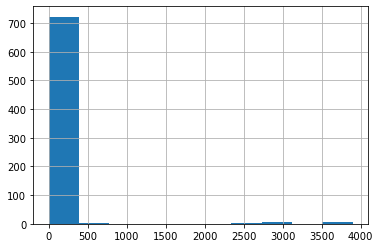

In [15]:
spatial_join.distances.hist()

In [16]:
spatial_join[spatial_join.distances <= 10][['BPH', 'type']].groupby('type').agg('mean')

,BPH
type,
Bike Lane,9.677855
Bike Route,9.588360
Neighborhood Greenway,12.016228
Pedestrian and Bicycle Access Way,10.154583
Shared Use Path,13.894033


In [17]:
spatial_join[spatial_join.distances > 10][['BPH', 'type']].groupby('type').agg('mean')

,BPH
type,
Bike Lane,3.625964
Bike Route,3.099959
Connectivity for Routing,1.118775
Neighborhood Greenway,6.295846
Paved Shoulder,2.320472
Pedestrian and Bicycle Access Way,3.400949
Shared Use Path,3.999423


In [18]:
spatial_join[['BPH', 'Locatin', 'type']].groupby('type').agg({"BPH": np.mean, "Locatin": pd.Series.nunique})

,BPH,Locatin
type,,
Bike Lane,9.175351,75
Bike Route,8.134063,28
Connectivity for Routing,1.118775,2
Neighborhood Greenway,11.158171,16
Paved Shoulder,2.320472,3
Pedestrian and Bicycle Access Way,7.260169,4
Shared Use Path,13.165360,50


In [19]:
spatial_join.columns

Index(['Locatin', 'Year', 'BPH', 'Latitud', 'Longitd', 'Site_Nm', 'DblCntL',
       'IsOnewy', 'OnwyDrc', 'IsSdwlk', 'geometry', 'index_right', 'name',
       'type', 'lane_type', 'source', 'distances'],
      dtype='object')

In [20]:
spatial_join.lane_type.unique()

array([None, 'Protected Bikeway', 'Shared Lane Marking',
       'Buffered Bike Lane'], dtype=object)

In [21]:
spatial_join[(spatial_join.distances <= 10) & (spatial_join['type'] == 'Bike Lane')][['BPH', 'lane_type']].groupby('lane_type').agg('mean')

,BPH
lane_type,
Buffered Bike Lane,14.048335
Protected Bikeway,19.272174


In [22]:
spatial_join[(spatial_join.distances <= 10)][['BPH', 'lane_type']].groupby('lane_type').agg('mean')

,BPH
lane_type,
Buffered Bike Lane,14.048335
Protected Bikeway,19.272174
Shared Lane Marking,1.528278


In [23]:
spatial_join[['BPH', 'lane_type']].groupby('lane_type').agg('mean')

,BPH
lane_type,
Buffered Bike Lane,14.048335
Protected Bikeway,17.867255
Shared Lane Marking,1.528278


In [24]:
spatial_join_n = spatial_join[spatial_join.distances <= 10]

In [25]:
sj_lane = spatial_join_n[spatial_join_n['type'] == 'Bike Lane'][['BPH', 'lane_type', 'Locatin']]

In [26]:
#sj_lane[sj_lane.lane_type.isnull()]
sj_lane.fillna("Bike Lane",inplace=True)

In [27]:
sj_lane.groupby('lane_type').agg('mean')

,BPH
lane_type,
Bike Lane,6.535361
Buffered Bike Lane,14.048335
Protected Bikeway,19.272174


In [28]:
bph_type = spatial_join_n[['BPH', 'Locatin', 'type']].groupby('type').agg({"BPH": np.mean, "Locatin": pd.Series.nunique})

In [29]:
bph_type

,BPH,Locatin
type,,
Bike Lane,9.677855,65
Bike Route,9.588360,23
Neighborhood Greenway,12.016228,14
Pedestrian and Bicycle Access Way,10.154583,1
Shared Use Path,13.894033,45


In [30]:
def get_df(dat=bph_type):
    data = {'name':dat.index.values,'bph':dat.BPH.values, 'loct':dat.Locatin.values}
    df = pd.DataFrame(data)
    df = df.sort_values(by=['bph'], ignore_index=True)
    return df

In [31]:
outpath = r"T:\DCProjects\StoryMap\BikeCounting\figures"

In [44]:
def plot_bph(dat=bph_type, x = np.array(range(0,5)), axis_range=[0, 6.5, 9, 14.5], 
             adjust_label = False, adj_p = 0, adj_d = 0.2,
             outname="bph_facility_type"):
    df = get_df(dat=dat)
    fig, ax = plt.subplots(figsize=(12,8))
    plt.xticks(x, "")
    plt.plot(x, df.bph, linewidth=4)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    #top_side = ax.spines["top"]
    #top_side.set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    plt.tick_params(axis='y', labelsize=16)
    for index in range(len(x)):
        if adjust_label:
            if index == adj_p:
                ax.text(x[index], df.bph[index]-adj_d, df.name[index] + ", " + str(round(df.bph[index], 2)) + " (" + str(df.loct[index]) + ")", size=16)
            else:
                ax.text(x[index], df.bph[index], df.name[index] + ", " + str(round(df.bph[index], 2)) + " (" + str(df.loct[index]) + ")", size=16)
        else:
            ax.text(x[index], df.bph[index], df.name[index] + ", " + str(round(df.bph[index], 2)) + " (" + str(df.loct[index]) + ")", size=16)
    plt.axis(axis_range)
    plt.ylabel("Average Bikes Per Hour", size=16)
    plt.savefig(os.path.join(outpath, outname+".png"))

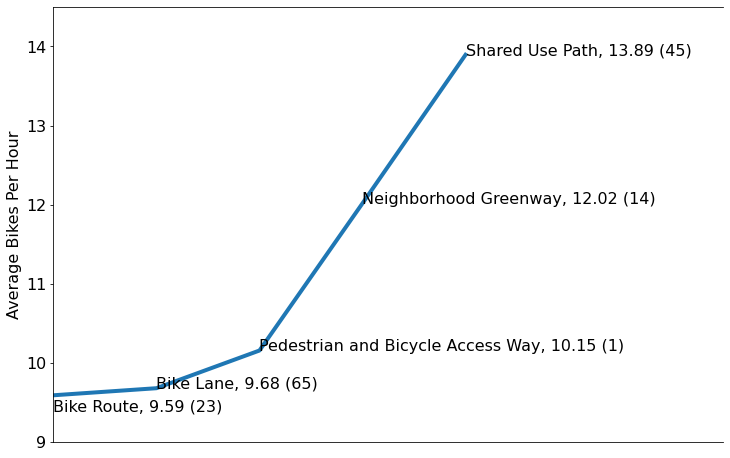

In [45]:
plot_bph(adjust_label = True)

In [34]:
bph_lane = sj_lane[['BPH', 'Locatin', 'lane_type']].groupby('lane_type').agg({"BPH": np.mean, "Locatin": pd.Series.nunique})

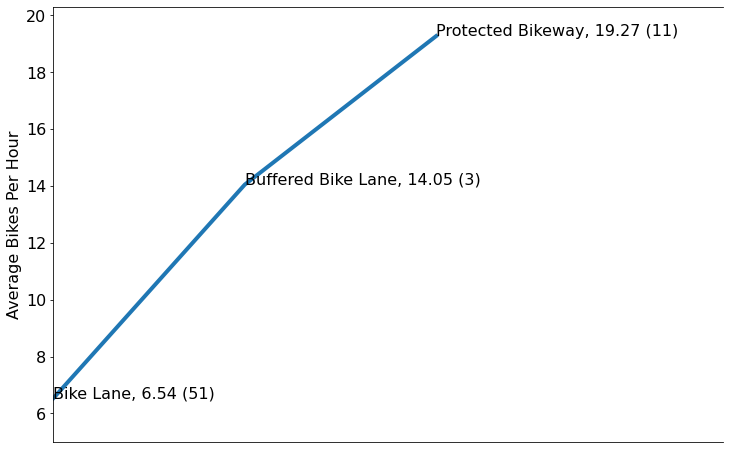

In [35]:
plot_bph(dat=bph_lane, x = np.array(range(0,3)), axis_range=[0, 3.5, 5, 20.3], outname="bph_lane_type")